# Capstone project -- Opening a restaurant

## Introduction and business problem

### Problem Description

Nowadays, it is difficult to imagine a city without a restaurant or a venue for food where people can have a meal or drink. The city of my choose is Taganrog that is the leading historic, cultural and industrial center in the South of Russia. Local industry and businesses are represented by aerospace, machine-building, military, iron and steel industry, farming, food, theathers, museums and one of the major ports of Azov Sea. That means there are a lot of business opportunities for restaurant business what leads to high competition.

To survive in such competitive market it is very important to find right place and take into account many other important factors such as:
* City population
* Sport and Entertainment zones
* Food markets with products of local farmers
* Local competitors and their ratings
* etc

In order to reduce the risks and avoid loss of money, the analysis of all accessible data should be carried out carefully in order to choose a suitable place or location. In my opinion, even an amazing idea or ingenious concept will not make your restaurant business successful without suitable place for it.

Obviously, this project will be interesting for a big company as well as anyone who wants to open a new restaurant in Taganrog city.


## Data description

The city of <b>Taganrog</b> (located in the South of Russia) will be analyzed in this project.

To solve the problem of finding the right location, we should find all existing businesses in the city of interest, explore them carefully to understand what we already have and plot our venues on map to gain insights, possible patterns or clusters.

For further analysis we will use the following data sources:
1. Wikipedia page for city population (https://en.wikipedia.org/wiki/Taganrog)
2. Nominatim search engine for OpenStreetMap data to get the bounding box of the city
    (https://nominatim.openstreetmap.org/search?format=json&q=Taganrog&polygon_geojson=1)
3. Foursquare API

Foursquare will be used as the main data source for analysis. We will retrieve both geographical coordinates and additional information about each venue using Foursquare API.

The following attributes for each venue will be collected:
* Id -- venue id (in order to remove duplicates)
* Venue -- venue name
* Category -- venue category
* Location -- venue address
* Latitude -- venue latitude
* Longitude -- venue longitude
* Rating -- numerical rating of the venue (0 through 10)
* Tips -- total count of tips
* Likes -- the count of users who have liked this venue

Because of Taganrog city has no neighborhood division like cities in the United States, we will build a coordinate grid that will cover the entire city by cells (or squares) of size 0.005x0.005 or 700x700 metre approximately.
South-west (sw) and north-east (ne) corners of cells will be utilized as input for the <b>search</b> endpoint of Foursquare API.

#### Example of coordinate grid

In [432]:
url_bounds = 'https://nominatim.openstreetmap.org/search?format=json&q=Taganrog, Russia&polygon_geojson=1'
# get borders in json format
result = requests.get(url_bounds).json()[0]
bounds = result['boundingbox']

# convert to float
city_rect = [float(i) for i in bounds] 
city_center = [float(result['lat']), float(result['lon'])]

# city south-west corner
city_sw = [city_rect[0], city_rect[2]]
# city north-east corner
city_ne=[city_rect[1], city_rect[3]]

print('city rect:', city_rect)
print('city center:', city_center)

city rect: [47.1887122, 47.2899427, 38.7929772, 38.9701473]
city center: [47.2153657, 38.9285216]


In [75]:
grid_step = 0.005
map_tag = folium.Map(location=city_center, zoom_start=12)
for lat in np.arange(city_rect[0], city_rect[1], grid_step):
    for lon in np.arange(city_rect[2], city_rect[3], grid_step):
        folium.Rectangle([[lat, lon], [lat+grid_step, lon+grid_step]], color='red', weight=0.3).add_to(map_tag)

map_tag.fit_bounds([city_sw, city_ne])        
map_tag

#### Example of data from Foursquare
The first five venues within 700 meters bounding box of city center are below:

In [305]:
# first five rows

Venue   Latitude  Longitude        Category  \
0  Площадь перед администрацией города  47.215733  38.928230           Plaza   
1                           Культ вина  47.215510  38.929310        Wine Bar   
2             Театр имени А. П. Чехова  47.216325  38.928217         Theater   
3              Администрация Таганрога  47.215517  38.928420       City Hall   
4                             Л'Этуаль  47.215416  38.929266  Cosmetics Shop   

                         Id  
0  5368f4ad498ea0cb80cef632  
1  5c74142e60255e002c1aefbc  
2  4dcbe98a1f6ea1401d49d12a  
3  4da693d90cb66f658708dafc  
4  4f83002ee4b0b2237e8a6cb1

When data collected, the general approach to solution is to cluster venues in the city and identify what cluster fit best of all. It may either be a cluster with the most popular venues for food or a cluster having similar parameters but the least venues for food.

## Data collection
This section covers data acquisition steps.

Let's import all necessary packages

In [1]:
import numpy as np 
import pandas as pd
import json 

from geopy.geocoders import Nominatim

import requests 
from pandas.io.json import json_normalize

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium 
import time

import matplotlib.pyplot as plt

##### Define Foursquare Credentials and Version

In [1]:
# Pull API keys from the file
with open('4square_keys.txt','r') as f:
    CLIENT_ID, CLIENT_SECRET = [l.strip() for l in f.readlines()]

VERSION = '20180604'
LIMIT = 500

Define a function to search venues located within a specified rectangle.

In [54]:
def searchVenuesInRect(sw, ne):
    
    venues_list=[]
    
    def get_category(cat_list):
        if len(cat_list) == 0: return None
        else: return cat_list[0]['name']
              
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&intent=browse&sw={},{}&ne={},{}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, 
            sw[0], sw[1], ne[0], ne[1],
            LIMIT)
            
    # make the GET request
    results = requests.get(url).json()['response']['venues']
        
    # return only relevant information for each nearby venue
    venues_list.append([(
        v['name'], 
        v['location']['lat'], 
        v['location']['lng'],  
        get_category(v['categories']),
        v['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Venue', 'Latitude', 'Longitude', 'Category', 'Id']
    
    return(nearby_venues)
        

#### Get the city bounding box using Nominatim search engine for OpenStreetMap data 

In [28]:
url_bounds = 'https://nominatim.openstreetmap.org/search?format=json&q=Taganrog, Russia&polygon_geojson=1'
# get borders in json format
result = requests.get(url_bounds).json()[0]
bounds = result['boundingbox']

# convert to float
city_rect = [float(i) for i in bounds] 
city_center = [float(result['lat']), float(result['lon'])]

# city south-west corner
city_sw = [city_rect[0], city_rect[2]]
# city north-east corner
city_ne=[city_rect[1], city_rect[3]]

print('city rect:', city_rect)
print('city center:', city_center)

city rect: [47.1887122, 47.2899427, 38.7929772, 38.9701473]
city center: [47.2153657, 38.9285216]


#### Get the list of all venues in the city iterating over cell of coordinate grid

In [ ]:
grid_step = 0.005
city_venues = pd.DataFrame(columns=['Venue', 'Latitude', 'Longitude', 'Category', 'Id'])
for lat in np.arange(city_rect[0], city_rect[1], grid_step):
    for lon in np.arange(city_rect[2], city_rect[3], grid_step):
        loc_venues = searchVenuesInRect(sw=[lat, lon], ne=[lat+grid_step, lon+grid_step])
        city_venues = city_venues.append(loc_venues)

print(city_venues.shape)
city_venues.head()

Drop all venues that have an empty **Category** field.

In [472]:
city_venues = city_venues.dropna(subset=['Category'])

Remove all duplicated venues.

In [ ]:
city_venues = city_venues.drop_duplicates('Id')
city_venues = city_venues.reset_index(drop=True)

##### Save the dataset to csv.

In [40]:
# save dataframe to csv file
city_venues.to_csv('city_venues.csv', index=False)

### Get categories
Now pull all possible categories from Foursquare using its API endpoint **categories** and define a function to determine venues for food among all city venues.

In [36]:
url_cat = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
url_cat

'https://api.foursquare.com/v2/venues/categories?client_id=V53MHPBBL23EVUFTF31HTKJAFRJIK2QL1WJURTZ3ARRFF3KE&client_secret=G5Z0ALDAAKEOPESPXKBZPXNB2TIEJKGWM33ZGSBCNW0VGW0T&v=20180604'

In [37]:
result = requests.get(url_cat).json()
df_cat = json_normalize(result['response']['categories'])
df_cat.head()

id                  name               pluralName  \
0  4d4b7104d754a06370d81259  Arts & Entertainment     Arts & Entertainment   
1  4d4b7105d754a06372d81259  College & University  Colleges & Universities   
2  4d4b7105d754a06373d81259                 Event                   Events   
3  4d4b7105d754a06374d81259                  Food                     Food   
4  4d4b7105d754a06376d81259        Nightlife Spot          Nightlife Spots   

              shortName                                         categories  \
0  Arts & Entertainment  [{'id': '56aa371be4b08b9a8d5734db', 'name': 'A...   
1   College & Education  [{'id': '4bf58dd8d48988d198941735', 'name': 'C...   
2                 Event  [{'id': '52f2ab2ebcbc57f1066b8b3b', 'name': 'C...   
3                  Food  [{'id': '503288ae91d4c4b30a586d67', 'name': 'A...   
4             Nightlife  [{'id': '4bf58dd8d48988d116941735', 'name': 'B...   

                                         icon.prefix icon.suffix  
0  https://ss3.4sqi.net/img/categories_v2/arts_en...        .png  
1  https://ss3.4sqi.net/img/categories_v2/educati...        .png  
2  https://ss3.4sqi.net/img/categories_v2/event/d...        .png  
3  https://ss3.4sqi.net/img/categories_v2/food/de...        .png  
4  https://ss3.4sqi.net/img/categories_v2/nightli...        .png

In [38]:
def findCategory(cat_list, cat_id):
    if len(cat_list) == 0: return False
    df = json_normalize(cat_list)
    if df[df.id == cat_id].shape[0] > 0: return True
    for c in df.categories: 
        if findCategory(c, cat_id): return True
    return False

def isFoodCategory(df, cat_id):
    food_id = '4d4b7105d754a06374d81259'
    if cat_id == food_id: return True
    if findCategory(df.loc[df.id == food_id, 'categories'].to_list()[0], cat_id): return True
    return False

Add new field **Food_venue** to identify the venue for food and convert booleans to integers i.e 0 and 1 values.

In [ ]:
mask = city_venues['Category_id'].map(lambda x: isFoodCategory(df_cat, x))
food_venues = city_venues.loc[mask]
city_venues['Food_venue'] = mask * 1

In [434]:
display_cols = ['Venue', 'Latitude', 'Longitude', 'Category', 'Food_venue']
city_venues[display_cols].head()

Venue   Latitude  Longitude  \
0  Место Разворота Маршруток  47.202091  38.854572   
1          Ресторан Пирамила  47.217564  38.855255   
2               штрафстоянка  47.221715  38.831101   
3                    ДокАвто  47.223408  38.858902   
4                   Евролюкс  47.224610  38.844511   

                      Category  Food_venue  
0                     Bus Line           0  
1  Eastern European Restaurant           1  
2                      Parking           0  
3                  Gas Station           0  
4               General Travel           0

Let's display venues on map. To this purpose define a function **plot_venues_with_rect** which will display venues the city bounding box using folium library.

In [33]:
# plot venues on map
def plot_venues(venues, loc):
    map_ = folium.Map(location=loc, zoom_start=13)
   
    # add markers to map
    for lat, lng, name, cat in zip(venues['Latitude'], venues['Longitude'], venues['Venue'], venues['Category']):
        label = '{}, {}'.format(name, cat)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_)  
        
    return map_

In [34]:
# plot venues with rectangle on map
def plot_venues_with_rect(venues, sw, ne):
    map_ = plot_venues(venues, sw)
    # add bounding box 
    map_.fit_bounds([sw, ne])
    folium.Rectangle([sw, ne], color='red').add_to(map_)
    return map_

In [50]:
plot_venues_with_rect(food_venues, [city_rect[0], city_rect[2]], [city_rect[1], city_rect[3]])

### Get detailed information about each venue

Define auxiliary functions to get the venue's details.

In [19]:
# Get the venue's overall rating
def rating_value(venue):
    try: return venue['response']['venue']['rating']
    except: return 0

# Get the number of tips
def tips_count(venue):
    try: return venue['response']['venue']['tips']['count']
    except: return 0

# Get the number of likes
def likes_count(venue):
    try: return venue['response']['venue']['likes']['count']
    except: return 0

def api_call_succeeded(json):
    try: return json['meta']['code'] == 200
    except: return False

# get postal code or 347900 if absent
def postal_code(venue):
    try: return venue['response']['venue']['location']['postalCode']
    except: return 347900
    
# get category id of a venue
def category_id(venue):
    try: 
        cat_list = venue['response']['venue']['categories']
    except: 
        return None
    
    if len(cat_list) == 0: 
        return None
    else: 
        return cat_list[0]['id']
    
# the price tier from 1 (least pricey) - 4 (most pricey)
def price_tier(venue):
    try: return venue['response']['venue']['price']['tier']
    except: return 0
    
# Seconds since epoch when the venue was created.
def createdAt(venue):
    try: return (venue['response']['venue']['createdAt'])
    except: return 0    

Define a funtion to pull details from Foursquare by venue id.

In [13]:
def get_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    response = requests.get(url)
    if response.ok:
        result = response.json()
        return [api_call_succeeded(result),
                rating_value(result), 
                likes_count(result), 
                tips_count(result),
                postal_code(result),
                price_tier(result),
                createdAt(result),
                category_id(result)]
    else:
        return [False, None, None, None, None, None, None, None]


### Create a new dataset for venue's details

In [73]:
all_details = pd.DataFrame(columns=['Id', 'processed', 'Rating', 'Likes', 'Tips', 'PostalCode', 'Price_tier', 'createdAt', 'Category_id'])
all_details['Id'] = city_venues['Id']
print(all_details.shape)
all_details.head()

(3525, 9)


Id processed Rating Likes Tips PostalCode Price_tier  \
0  55a0e60c498e873de699ccd1       NaN    NaN   NaN  NaN        NaN        NaN   
1  58401718e9233e42ab37615e       NaN    NaN   NaN  NaN        NaN        NaN   
2  51ecf0f2498edbbbb8c6c29d       NaN    NaN   NaN  NaN        NaN        NaN   
3  53f917c4498e47b1dc40249e       NaN    NaN   NaN  NaN        NaN        NaN   
4  516166d9e4b0d19a95e6b214       NaN    NaN   NaN  NaN        NaN        NaN   

  createdAt Category_id  
0       NaN         NaN  
1       NaN         NaN  
2       NaN         NaN  
3       NaN         NaN  
4       NaN         NaN

#### Fill in the dataset with data

In [22]:
import time
for ind in np.arange(all_details.shape[0]):
    if all_details.at[ind, 'processed'] != True:        
        all_details.iloc[ind, 1:] = get_details(all_details.iloc[ind, 0])
        time.sleep(0.4) # delay in seconds
    
all_details.loc[all_details['processed'] == True].shape

(3525, 9)

In [29]:
print(all_details.shape)
all_details.loc[all_details['processed'] == True].shape

(3525, 9)


(3525, 9)

In [30]:
# drop the temporary column 'processed'
all_details = all_details.drop('processed', 1)
all_details.head()

Id  Rating  Likes  Tips PostalCode  Price_tier  \
0  55a0e60c498e873de699ccd1     0.0    7.0   0.0     347900         0.0   
1  58401718e9233e42ab37615e     5.8    1.0   0.0     347900         0.0   
2  51ecf0f2498edbbbb8c6c29d     0.0    0.0   0.0     347900         0.0   
3  53f917c4498e47b1dc40249e     0.0    1.0   0.0     347900         0.0   
4  516166d9e4b0d19a95e6b214     0.0    0.0   0.0     347900         0.0   

      createdAt               Category_id  
0  1.436608e+09  4bf58dd8d48988d132951735  
1  1.480595e+09  52f2ab2ebcbc57f1066b8b46  
2  1.374483e+09  4bf58dd8d48988d1e2941735  
3  1.408833e+09  4bf58dd8d48988d1de941735  
4  1.365338e+09  4bf58dd8d48988d12b951735

#### Save details dataframe to csv file

In [32]:
# save dataframe to csv file
all_details.to_csv('city_venues_details.csv', index=False)

#### Join two datasets into a new one using venue id

In [39]:
city_venues = city_venues.join(all_details.set_index('Id'), on='Id')
city_venues.head()

Venue   Latitude  Longitude     Category  \
0               золотое руно  47.176498  38.810475   Hotel Pool   
1                  Пятерочка  47.182352  38.818977  Supermarket   
2          Петрушанская Коса  47.174113  38.865204        Beach   
3             село Боцманово  47.173903  38.755930     Vineyard   
4  Остановка "Новозолотовка"  47.179577  38.795387     Bus Line   

                         Id  Rating  Likes  Tips PostalCode  Price_tier  \
0  55a0e60c498e873de699ccd1     0.0    7.0   0.0     347900         0.0   
1  58401718e9233e42ab37615e     5.8    1.0   0.0     347900         0.0   
2  51ecf0f2498edbbbb8c6c29d     0.0    0.0   0.0     347900         0.0   
3  53f917c4498e47b1dc40249e     0.0    1.0   0.0     347900         0.0   
4  516166d9e4b0d19a95e6b214     0.0    0.0   0.0     347900         0.0   

      createdAt               Category_id  
0  1.436608e+09  4bf58dd8d48988d132951735  
1  1.480595e+09  52f2ab2ebcbc57f1066b8b46  
2  1.374483e+09  4bf58dd8d48988d1e2941735  
3  1.408833e+09  4bf58dd8d48988d1de941735  
4  1.365338e+09  4bf58dd8d48988d12b951735

# Methodology

This section focuses on data understanding and data preparation of previously collected data, exploratory analysis, and clustering. 

* Understanding and preparation: the data needs to be cleaned and prepared: fields renamed, NaN's fixed;

* Exploratory analysis includes check field distributions, detect any outliers, exploring correlation between fields and discarding erroneous or not needed data;
    
* Clustering -- the core Machine Learning methodology and a very popular clustering algorithm, called k-means is used in this project. The major focus of the project is to determine the optimum number of clusters and finding suitable cluster for a new restaurant. 
    

### Understanding and preparation
Let's load and see the dataset of venues.

In [84]:
city_venues = pd.read_csv('city_venues.csv')
print(city_venues.shape)
city_venues.head()

(3525, 12)


Venue   Latitude  Longitude     Category  \
0               золотое руно  47.176498  38.810475   Hotel Pool   
1                  Пятерочка  47.182352  38.818977  Supermarket   
2          Петрушанская Коса  47.174113  38.865204        Beach   
3             село Боцманово  47.173903  38.755930     Vineyard   
4  Остановка "Новозолотовка"  47.179577  38.795387     Bus Line   

                         Id  Rating  Likes  Tips  PostalCode  Price_tier  \
0  55a0e60c498e873de699ccd1     0.0    7.0   0.0    347900.0         0.0   
1  58401718e9233e42ab37615e     5.8    1.0   0.0    347900.0         0.0   
2  51ecf0f2498edbbbb8c6c29d     0.0    0.0   0.0    347900.0         0.0   
3  53f917c4498e47b1dc40249e     0.0    1.0   0.0    347900.0         0.0   
4  516166d9e4b0d19a95e6b214     0.0    0.0   0.0    347900.0         0.0   

      createdAt               Category_id  
0  1.436608e+09  4bf58dd8d48988d132951735  
1  1.480595e+09  52f2ab2ebcbc57f1066b8b46  
2  1.374483e+09  4bf58dd8d48988d1e2941735  
3  1.408833e+09  4bf58dd8d48988d1de941735  
4  1.365338e+09  4bf58dd8d48988d12b951735

In [85]:
# examine column's types
city_venues.dtypes

Venue           object
Latitude       float64
Longitude      float64
Category        object
Id              object
Rating         float64
Likes          float64
Tips           float64
PostalCode     float64
Price_tier     float64
createdAt      float64
Category_id     object
dtype: object

#### Display collected venues on map
Here we define two function for displaying venues on map: plot_venues and plot_venues_with_rect.

In [86]:
# define a function to plot venues on map
def plot_venues(venues, loc):
    map_ = folium.Map(location=loc, zoom_start=13)
   
    # add markers to map
    for lat, lng, name, cat in zip(venues['Latitude'], venues['Longitude'], venues['Venue'], venues['Category']):
        label = '{}, {}'.format(name, cat)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_)  
    return map_

# plot venues with rectangle on map
def plot_venues_with_rect(venues, sw, ne):
    map_ = plot_venues(venues, sw)
    # add bounding box 
    map_.fit_bounds([sw, ne])
    folium.Rectangle([sw, ne], color='red').add_to(map_)
    return map_

In [88]:
# for some reason, the max number of venues the folium can display is 1500 
plot_venues_with_rect(city_venues.iloc[1500:3000], sw=city_sw, ne=city_ne)

We can see outliers on map i.e. there are some venues out of city bounding box. Let' remove them.

#### Remove venues out of the bounding box

In [91]:
city_venues = city_venues[
    ((city_venues['Latitude'] > city_sw[0]) & (city_venues['Latitude'] < city_ne[0]) &
     (city_venues['Longitude'] > city_sw[1]) & (city_venues['Longitude'] < city_ne[1]))]

city_venues.shape

(3424, 12)

In [90]:
#look again at venues on map
plot_venues_with_rect(city_venues.iloc[1500:3000], sw=city_sw, ne=city_ne)

In [92]:
# save dataframe to csv file
city_venues.to_csv('city_clean.csv', index=False)

### Exploratory Analysis

Let's examine the **'createdAt'** field. This field contains amount of seconds since epoch when the venue was created.
Let's convert timestamp in seconds to years and find a range of years.

In [127]:
city_venues['Created_year'] = city_venues['createdAt'].apply(lambda t: time.gmtime(t).tm_year)
city_venues['Created_year'].describe()

count    3424.000000
mean     2013.328855
std         1.597335
min      2010.000000
25%      2012.000000
50%      2013.000000
75%      2014.000000
max      2019.000000
Name: Created_year, dtype: float64

In [128]:
city_venues['Venue_age'] = city_venues['Created_year'].apply(lambda y: 2019 - y)
city_venues['Venue_age'].describe()

count    3424.000000
mean        5.671145
std         1.597335
min         0.000000
25%         5.000000
50%         6.000000
75%         7.000000
max         9.000000
Name: Venue_age, dtype: float64

We have transformed the 'createdAt' column in two new columns: 'Created_year' and 'Venue_age' and can drop it now.

In [129]:
city_venues = city_venues.drop('createdAt', 1)

Let's explore the **'Created_year'** field and plot its histogram.

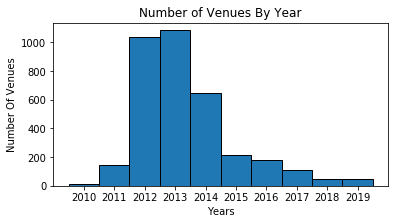

In [28]:
bins = np.arange(2010, 2021)
ax = city_venues.Created_year.plot(kind='hist', figsize=(6, 3), bins=bins, xticks=bins[:-1], edgecolor="k", align='left')

plt.title('Number of Venues By Year') # add a title to the histogram
plt.ylabel('Number Of Venues') # add y-label
plt.xlabel('Years') # add x-label

plt.show()

Now, let's examine the **'PostalCode'** field.

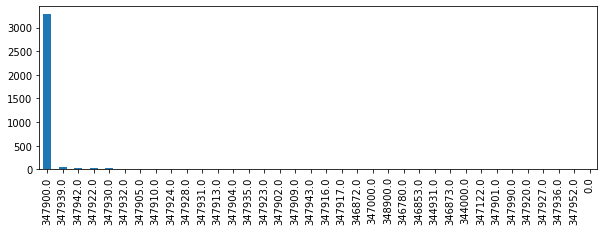

In [18]:
city_venues['PostalCode'].value_counts().plot(kind='bar', figsize=(10,3))

It is obvious that this column is useless because majority venues have postal code equal to 347900. Drop this column as well.

In [135]:
city_venues = city_venues.drop('PostalCode', 1)
city_venues.head()

Venue   Latitude  Longitude  \
0  Место Разворота Маршруток  47.202091  38.854572   
1          Ресторан Пирамила  47.217564  38.855255   
2               штрафстоянка  47.221715  38.831101   
3                    ДокАвто  47.223408  38.858902   
4                   Евролюкс  47.224610  38.844511   

                      Category                        Id  Rating  Likes  Tips  \
0                     Bus Line  5183984a498e46c7f9c5af0a     0.0    0.0   1.0   
1  Eastern European Restaurant  52f6564c498e9e09e3e33147     0.0    0.0   0.0   
2                      Parking  54bba83b498efc89a60986e4     0.0    0.0   0.0   
3                  Gas Station  5275e250498ed7d6b3483e96     0.0    0.0   0.0   
4               General Travel  506bf89fe4b0101523e50d28     0.0    1.0   0.0   

   Price_tier               Category_id  Food_venue  Created_year  Venue_age  
0         0.0  4bf58dd8d48988d12b951735           0          2013          6  
1         2.0  4bf58dd8d48988d109941735           1          2014          5  
2         0.0  4c38df4de52ce0d596b336e1           0          2015          4  
3         0.0  4bf58dd8d48988d113951735           0          2013          6  
4         0.0  4bf58dd8d48988d1f6931735           0          2012          7

Next let's explore the **'Rating'** field.

In [104]:
#city_venues.groupby('Rating').count()
city_venues.Rating.plot(kind='hist', bins = 10)
plt.title('Rating histogram')
plt.xlabel('Rating - (0, 10)')

Text(0.5, 0, 'Rating - (0, 10)')

Here we see two seperate sets of venues -- one set with rating equal to 0 and second one greater than 0.
My hypothesis is that the second set consists of venues for food. Let's check it out and plot histogram of venues for food.

In [114]:
#city_venues = pd.read_csv('city_venues_in_box_with_food_field.csv')
food_venues = city_venues[city_venues['Food_venue'] == 1]
food_venues.Rating.plot(kind='hist', bins = 10)
plt.title('Rating of venues for food')
plt.xlabel('Rating - (0, 10)')

Text(0.5, 0, 'Rating - (0, 10)')

In [134]:
print('Number of venues with rating greater than 0 is {}.'.format(len(food_venues[food_venues.Rating > 0])))
print('Number of venues with tips greater than 0 is {}.'.format(len(food_venues[food_venues.Tips > 0])))
print('Number of venues with Price_tier greater than 0 is {}.'.format(len(food_venues[food_venues.Price_tier > 0])))

Number of venues with rating greater than 0 is 80.
Number of venues with tips greater than 0 is 208.
Number of venues with Price_tier greater than 0 is 385.


#### Correlation between fields

In [136]:
city_venues.corr()

Latitude  Longitude    Rating     Likes      Tips  Price_tier  \
Latitude      1.000000  -0.115304 -0.045754 -0.061645 -0.062015   -0.054484   
Longitude    -0.115304   1.000000  0.055542  0.068591  0.080413    0.087981   
Rating       -0.045754   0.055542  1.000000  0.495428  0.435916    0.153763   
Likes        -0.061645   0.068591  0.495428  1.000000  0.871930    0.144708   
Tips         -0.062015   0.080413  0.435916  0.871930  1.000000    0.203122   
Price_tier   -0.054484   0.087981  0.153763  0.144708  0.203122    1.000000   
Food_venue   -0.076316   0.088966  0.142334  0.128512  0.182537    0.673304   
Created_year -0.026311   0.025289 -0.151191 -0.128767 -0.117383    0.046388   
Venue_age     0.026311  -0.025289  0.151191  0.128767  0.117383   -0.046388   

              Food_venue  Created_year  Venue_age  
Latitude       -0.076316     -0.026311   0.026311  
Longitude       0.088966      0.025289  -0.025289  
Rating          0.142334     -0.151191   0.151191  
Likes           0.128512     -0.128767   0.128767  
Tips            0.182537     -0.117383   0.117383  
Price_tier      0.673304      0.046388  -0.046388  
Food_venue      1.000000      0.095791  -0.095791  
Created_year    0.095791      1.000000  -1.000000  
Venue_age      -0.095791     -1.000000   1.000000

Summary. Almost all variables demonstrate very weak positive and negative correlations except those that obviously related to each other. For example Tips, Likes and Rating correlate between each other as well as Food_venue and Food_tier.

### Clustering
The core of the analytic method is clustering of all venues in Taganrog city by its fields, 
determining the optimum number of clusters and find suitable cluster for a new restaurant.

In [207]:
venues_clustering = pd.get_dummies(food_venues[['Category']], prefix="", prefix_sep="")
filtered_columns = ['Latitude', 'Longitude', 'Rating', 'Likes', 'Tips', 'Price_tier', 'Venue_age']

# add filtered columns back to dataframe
venues_clustering[filtered_columns] = food_venues[filtered_columns]

# move filtered columns to be first
fixed_columns = list(venues_clustering.columns[-len(filtered_columns):]) + list(venues_clustering.columns[:-len(filtered_columns)])
venues_clustering = venues_clustering[fixed_columns]

print(venues_clustering.shape)
venues_clustering.head()

(434, 65)


Latitude  Longitude  Rating  Likes  Tips  Price_tier  Venue_age  \
1   47.217564  38.855255     0.0    0.0   0.0         2.0          5   
20  47.221634  38.858727     0.0    0.0   0.0         0.0          3   
22  47.214496  38.799913     0.0    2.0   0.0         0.0          0   
28  47.223416  38.858882     0.0    0.0   0.0         2.0          4   
57  47.219629  38.862787     6.3    5.0   1.0         1.0          5   

    Afghan Restaurant  American Restaurant  Asian Restaurant  ...  \
1                   0                    0                 0  ...   
20                  0                    0                 0  ...   
22                  0                    0                 0  ...   
28                  0                    0                 0  ...   
57                  0                    0                 0  ...   

    Russian Restaurant  Sandwich Place  Snack Place  Steakhouse  \
1                    0               0            0           0   
20                   0               0            0           0   
22                   0               0            0           0   
28                   0               0            0           0   
57                   0               0            0           0   

    Sushi Restaurant  Tea Room  Theme Restaurant  Turkish Restaurant  \
1                  0         0                 0                   0   
20                 0         0                 0                   0   
22                 0         0                 0                   0   
28                 1         0                 0                   0   
57                 0         0                 0                   0   

    Ukrainian Restaurant  Vegetarian / Vegan Restaurant  
1                      0                              0  
20                     0                              0  
22                     0                              0  
28                     0                              0  
57                     0                              0  

[5 rows x 65 columns]

Normalize the dataset.

In [208]:
from sklearn.preprocessing import StandardScaler
norm_values = StandardScaler().fit_transform(venues_clustering)
norm_values

array([[-2.97905094e-01, -2.53268777e+00, -4.69582329e-01, ...,
        -4.80569331e-02, -6.80413817e-02, -4.80569331e-02],
       [-7.33646923e-02, -2.38711958e+00, -4.69582329e-01, ...,
        -4.80569331e-02, -6.80413817e-02, -4.80569331e-02],
       [-4.67120287e-01, -4.85306743e+00, -4.69582329e-01, ...,
        -4.80569331e-02, -6.80413817e-02, -4.80569331e-02],
       ...,
       [ 2.94193264e+00, -1.56800637e-02, -4.69582329e-01, ...,
        -4.80569331e-02, -6.80413817e-02, -4.80569331e-02],
       [ 2.92176983e+00,  1.43448566e-03, -4.69582329e-01, ...,
        -4.80569331e-02, -6.80413817e-02, -4.80569331e-02],
       [ 2.88397291e+00,  1.84974190e-01, -4.69582329e-01, ...,
        -4.80569331e-02, -6.80413817e-02, -4.80569331e-02]])

In [283]:
max_k = 15
squared_distance = np.zeros(max_k)
for k in range(2,max_k):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(norm_values)
    squared_distance[k] = kmeans.inertia_
    print(k,sep=' ', end=' ', flush=True)

2 3 4 5 6 7 8 9 10 11 12 13 14 

In [285]:
plt.figure()
plt.plot(squared_distance)
plt.xlabel('K')
plt.ylabel('Avg distance')
plt.title('Average distances from points to their cluster centers')
plt.xlim([2,max_k])
plt.show()

#### Cluster venues
Run k-means to cluster all venues into 11 clusters.

In [296]:
num_clusters = 11

k_means = KMeans(init="k-means++", n_clusters=num_clusters, random_state=0)
k_means.fit(norm_values)
labels = k_means.labels_

print(labels[:10])

[1 6 5 1 2 1 6 6 6 6]


#### Assign labels to venues

In [297]:
food_venues['Labels'] = labels
food_venues['Labels'].value_counts()

C:\Users\POL\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1     162
6     146
4      27
7      23
2      18
10     15
3      12
9      10
8       9
0       7
5       5
Name: Labels, dtype: int64

#### Let's display our clustered venues on map

In [298]:
import matplotlib.cm as cm
import matplotlib.colors as colors

def plot_clusters(venues, center, kclusters):
    # create map
    map_clusters = folium.Map(location=[center[0], center[1]], zoom_start=12)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, cat, cluster in zip(venues['Latitude'], venues['Longitude'], venues['Category'], venues['Labels']):
        label = folium.Popup('Cluster' + str(cluster) + ' - ' + cat, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
       
    return map_clusters

In [299]:
# narrow displayed venues whose category is food
plot_clusters(food_venues, city_center, num_clusters)

Now let's create the new dataframe **clusters_df** with the top 5 venue's category for each cluster.

In [429]:
def createClustersRating(df_labeled, clusters):
    df = pd.DataFrame(columns=['Label','1st','2nd','3rd', '4th', '5th'])
    df['Label'] = range(0, clusters)    
    for c in range(0, clusters):
        s = df_labeled[df_labeled['Labels'] == c]['Category'].value_counts()
        df.iloc[c, 1:] = getClusterFirstFiveCategories(s)
    df['Total'] = df_labeled.groupby('Labels').count().Venue
    return df

def getClusterFirstFiveCategories(s):
    cat = []
    for i in range(0, 5):
        try: cat.append(s.index[i])
        except: cat.append(None)
    return cat

In [430]:
clusters_df = createClustersRating(food_venues, num_clusters)
clusters_df

Label                          1st                 2nd          3rd  \
0       0                 Dessert Shop                None         None   
1       1                   Restaurant    Sushi Restaurant  Pizza Place   
2       2         Fast Food Restaurant                None         None   
3       3                        Diner                None         None   
4       4  Eastern European Restaurant  Italian Restaurant   Restaurant   
5       5   Modern European Restaurant                None         None   
6       6                         Café           Cafeteria       Bistro   
7       7                  Coffee Shop                None         None   
8       8               Sandwich Place                None         None   
9       9                 Burger Joint                None         None   
10     10                       Bakery                None         None   

                     4th          5th  Total  
0                   None         None      7  
1            Snack Place    BBQ Joint    162  
2                   None         None     18  
3                   None         None     12  
4    Japanese Restaurant         Café     27  
5                   None         None      5  
6   Caucasian Restaurant  Pastry Shop    146  
7                   None         None     23  
8                   None         None      9  
9                   None         None     10  
10                  None         None     15

## Results
This section summarizes the results of clustering. Empirically we identified 11 clusters of venues, let us first see what these clusters are. 
To help with interpreting the data, let's sort the clusters by a meaningful attribute. A good candidate for such attribute is total number of venues in each cluster.

In [403]:
clusters_df.sort_values('Total', ascending=False)

Label                          1st                 2nd          3rd  \
1       1                   Restaurant    Sushi Restaurant  Pizza Place   
6       6                         Café           Cafeteria       Bistro   
4       4  Eastern European Restaurant  Italian Restaurant   Restaurant   
7       7                  Coffee Shop                None         None   
2       2         Fast Food Restaurant                None         None   
10     10                       Bakery                None         None   
3       3                        Diner                None         None   
9       9                 Burger Joint                None         None   
8       8               Sandwich Place                None         None   
0       0                 Dessert Shop                None         None   
5       5   Modern European Restaurant                None         None   

                     4th          5th  Total  
1            Snack Place    BBQ Joint    162  
6   Caucasian Restaurant  Pastry Shop    146  
4    Japanese Restaurant         Café     27  
7                   None         None     23  
2                   None         None     18  
10                  None         None     15  
3                   None         None     12  
9                   None         None     10  
8                   None         None      9  
0                   None         None      7  
5                   None         None      5

In the table above the data is sorted in descending order, with the highest total number at the top.

Clusters 1 and 6 are the biggest among others and represented by such venue categories as Cafe, Cafeteria, Sushi, Pizza, Snack ect. It shows that the number of restaurants are high and it is risky to open a restaurant similar to clusters 1 and 6. 

Cluster 4 contains of cuisines of different countries: Eastern European, Italian, Japanese.

The rest clusters have a small number of venues and introduced by a single category.

## Discussion

One interesting observation is that small restaurants (such as Cafe, Cafeteria, Sushi, Pizza, etc.) are over big restaurants.
There is a small number of restaurants of different cuisines and a recommendation might be to open a restaurant of national cuisine (for instance Indian Restaurant).

## Conclusion

The project analyzes venue similarity based on data obtained from Foursquare. 
The data needed cleaning as it contained nonexistent venues and missing data. We can observe a lack of restaurants of national cuisines and suitable cluster for opening a restaurant.

However, we wish Foursquare had returned more venues as the data was very sparse and difficult to use for clustering. In future work, it may also be useful to include data pertaining to schools, universities, and such. 
